In [1]:
import pandas as pd
import numpy as np

# Graphical lasso

The graphical lasso is a method proposed by Friedman et al. in 2007 to estimate a sparse graph through a sparse penalty.


This models assumes that the covariates we are analyzing have a multivariate Gaussian distribution with mean $\mu$ and covariance $\Sigma$.

Moreover it is known that if the $ij$-th components of the inverse of the covariance matrix $\Sigma^{-1} = \Theta$ is zero, than the two variables $i$ and $j$ are conditionally independent given the others variable.

Some papers proposed different methods to reach an approximate solution of the problem, typically they are based on the maximization of a likelihood, derived from the distribution, given as 

$$ \text{log det}\Theta - \text{tr}(S\Theta) $$

where $\Theta$ is the inverse of the covariance matrix and its the unknown graph we want to estimate, and $S$ is the empirical covariance of our data. 
If we have a matrix $X \in \mathcal{R}^{n \times d}$ than $S=\frac{1}{n}X^TX \in \mathcal{R}^{d \times d}$

Since the $\Theta$ is supposed to be sparse the final functional imposes also a sparse penalty on it.

$$ \hat{\Theta} = \underset{\Theta}{\text{argmin}}\left(\text{tr}(S\Theta) - \text{log det}(\Theta) + \lambda\sum_{j\neq k}|\Theta_{jk}|\right)$$

## In this lab you are going infer a sparse network in two flavors:
    
    -Supervised
    -Unsupervised
    
**More specifically, you will be given n observations, drawn from a fully specified multivariate Gaussian distribution, whose precision matrix is known. You will infer a precision matrix by maximizing a score in a cross-validation scheme (supervised) and then you will assume you do not know the underlying distribution (*i.e.* the precision matrix) and will try to infer a precision matrix in an unsupervised manner.**

Define the distribution, the number of samples, variables

In [2]:
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLasso
from sklearn.covariance import GraphicalLassoCV
%matplotlib inline

np.random.seed(20)

In [3]:
data = np.load('data.npy')

In [4]:
data.shape

(100, 100)

**The precision matrix is the following `precision`**

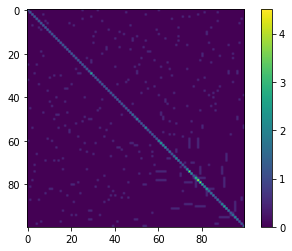

In [5]:
precision = np.load('precision.npy')

plt.imshow(precision, cmap = 'viridis')
plt.colorbar()

In [6]:
precision.shape

(100, 100)

**You are going to use the sklearn [GraphLasso](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphicalLasso.html)**

Define a plausible list of parameters for the model

In [7]:
alphas = np.linspace(0.01, 1, num=20, retstep=True)

In [8]:
models = []
convmat = []
precmat = []
error = []
accuracy = []
for i in alphas[0]:
    model = GraphicalLasso(alpha=i,verbose=False)
    model.fit(data)
    cov_mat = model.covariance_
    convmat.append(cov_mat)
    pre_mat = model.precision_
    precmat.append(pre_mat)
    model.score(pre_mat)
    error.append(np.mean( pre_mat != precision ))
    accuracy.append(np.mean(pre_mat==precision))
    models.append(model)

/home/mose/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.971e-03
  warnings.warn('graphical_lasso: did not converge after '


In [9]:
alphas[0][accuracy.index(max(accuracy))]

0.4789473684210527

Text(0, 0.5, 'Model Accuracy')

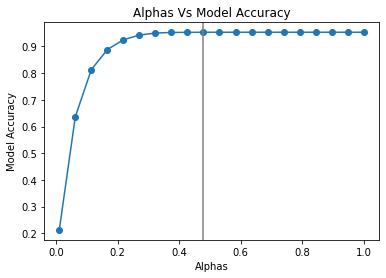

In [10]:
plt.plot(alphas[0],accuracy,'o-')
plt.axvline(alphas[0][accuracy.index(max(accuracy))], color='.5')
plt.title("Alphas Vs Model Accuracy")
plt.xlabel("Alphas")
plt.ylabel("Model Accuracy")

In [11]:
#Best model
best_model_precision = precmat[accuracy.index(max(accuracy))]

In [12]:
#Model accuracy
np.mean(precision == best_model_precision )

0.9534

In [13]:
best_model = models[accuracy.index(max(accuracy))]

In [14]:
best_model.get_params()

{'alpha': 0.4789473684210527,
 'assume_centered': False,
 'enet_tol': 0.0001,
 'max_iter': 100,
 'mode': 'cd',
 'tol': 0.0001,
 'verbose': False}

In [15]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
pairwise_distances(precision, best_model_precision, metric='hamming')

array([[0.04, 0.05, 0.05, ..., 0.07, 0.07, 0.05],
       [0.05, 0.04, 0.05, ..., 0.07, 0.07, 0.05],
       [0.05, 0.05, 0.04, ..., 0.07, 0.07, 0.05],
       ...,
       [0.05, 0.05, 0.05, ..., 0.04, 0.07, 0.05],
       [0.05, 0.05, 0.05, ..., 0.07, 0.04, 0.05],
       [0.05, 0.05, 0.05, ..., 0.07, 0.07, 0.04]])

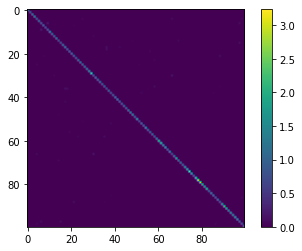

In [16]:
plt.imshow(best_model_precision , cmap = 'viridis')
plt.colorbar()

In [17]:
from sklearn.covariance import GraphicalLassoCV

model2 = GraphicalLassoCV(alphas=20,cv=10) # we are choosing 20 alphas to choose from and cross validatation of 10
model2.fit(data)
cov_mat_cv = model2.covariance_
pre_mat_cv = model2.precision_

/home/mose/.local/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [18]:
#Model 2 results in comparison to ground truth 
np.mean(precision!=pre_mat_cv )

0.1702

In [19]:
#Model 2 results in comparison to ground truth 
np.mean(pre_mat_cv==precision)

0.8298

In [116]:
model2.get_params(deep=True)

{'alphas': 20,
 'assume_centered': False,
 'cv': 10,
 'enet_tol': 0.0001,
 'max_iter': 100,
 'mode': 'cd',
 'n_jobs': None,
 'n_refinements': 4,
 'tol': 0.0001,
 'verbose': False}

In [102]:
#The chosen alpha
model2.alpha_

0.12343958007462313

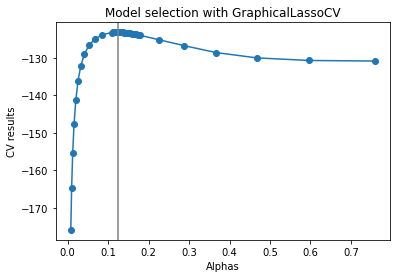

In [103]:
plt.plot(model2.cv_results_["alphas"], model2.cv_results_["mean_score"], 'o-')
plt.axvline(model2.alpha_, color='.5')
plt.title('Model selection with GraphicalLassoCV')
plt.ylabel('CV results')
plt.xlabel('Alphas')

plt.show()

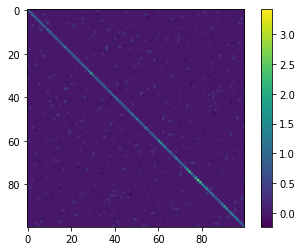

In [104]:
#Precision matrix for cross validated data
plt.imshow(pre_mat_cv, cmap = 'viridis')
plt.colorbar()

In [105]:
# Adjuncency Matrix we import in neworkx 
import networkx as nx

In [106]:
#Adjucency Matrix
G=nx.Graph(pre_mat_cv)
A = nx.adjacency_matrix(G)
adjacencyMat = A.todense()

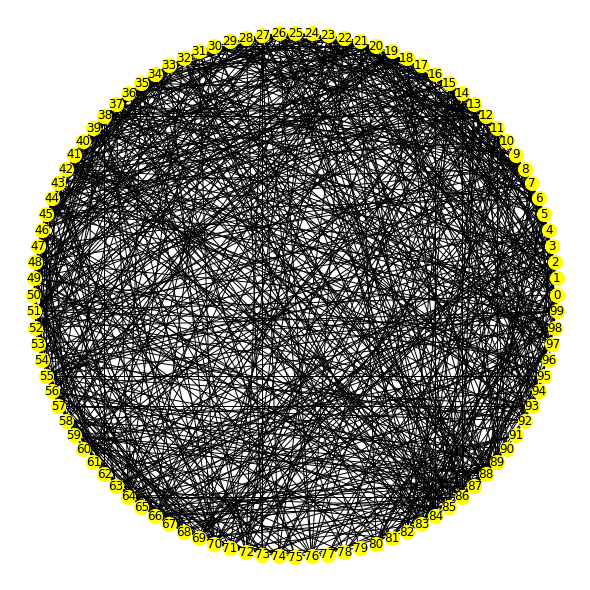

In [107]:
#Network diagram
plt.figure(figsize = (8,8))
nx.draw_circular(G,with_labels=True, node_size=200, node_color='yellow')

In [108]:
# Adjacency connections per node
connection = []
for i in G.adjacency():
    connection.append(i)
connection[0]

(0,
 {0: {'weight': 1.4292263934387346},
  15: {'weight': -0.017604366792782187},
  17: {'weight': 0.026873176895625968},
  21: {'weight': 0.11863322023365905},
  25: {'weight': 0.3415335246524416},
  29: {'weight': -0.007737463893204319},
  32: {'weight': 0.43377733207298685},
  42: {'weight': -0.07130993769741452},
  51: {'weight': -0.06840304960227843},
  60: {'weight': 0.19915826897775987},
  81: {'weight': 0.0011142424610436218},
  83: {'weight': 0.020977618940939958},
  88: {'weight': -0.04231321210586461},
  96: {'weight': 0.06774988584684591},
  99: {'weight': 0.03288707101578511}})

In [109]:
#Adjucency Matrix
Graph=nx.Graph(precision)
Aorig = nx.adjacency_matrix(Graph)
adjacencyMatorig = Aorig.todense()

In [110]:
#Humming distance
from scipy.spatial import distance
dist=distance.hamming(adjacencyMatorig.ravel,adjacencyMat.ravel ) #.ravel changes the matrix to 1 dim array. 
print(dist)

1.0


For each hyper-parameter in the list `alphas` fit a GraphicaLasso model to your data and choose the best one according to score of your choice (**Hint: remember that inferring the right edges is equivalent to inferring the right class in a binary classificaion problem**). For stability analysis, you could also try the same setting for different splits.

In [ ]:
from sklearn.covariance import GraphicalLasso

Define a function able to recover the corresponding adjacency matrix from an arbitrary square matrix

Compare the aground-truth adjacency matrix with the inferred one usign the **Hamming distance**

### Unsupervised learning of the precision matrix

Assume that you do not know the precision matrix of the underlying data distribution. You need to perform inference of the precision matrix only using your observations. Typically, in this setting, Probabilistic model selection (or “information criteria”) provides an analytical technique for scoring and choosing among candidate models.

You are going to use the **`Bayesian Information Criterion (BIC)`**, appropriate for models fit under the maximum likelihood estimation framework.

It is defined as:

$$BIC = -2LL + \log(N)k$$

where LL is the log-likelihood of the model, N is the number of examples in the training dataset, and k is the number of parameters in the model.

The score as defined above is minimized, e.g. the model with the lowest BIC is selected.

**Define a function for computing the BIC specific for the Graphical Lasso likelihood:**

$$ \text{log det}\Theta - \text{tr}(S\Theta) $$

In [122]:
model2.score(data)

-118.98518511370378

In [150]:
train = data[0:80,]
test = data[81:]
test.shape

(19, 100)

In [178]:

def bic(X):
    model = GraphicalLassoCV(alphas=20,cv=10)
    model.fit(X)
    prec = model.precision_
    return -2*(model.score(prec))+len(model.get_params()) * np.log(X.shape[0] 

In [163]:
results = bic(train)

/home/mose/.local/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [165]:
results[1].get_params()

{'alphas': 20,
 'assume_centered': False,
 'cv': 10,
 'enet_tol': 0.0001,
 'max_iter': 100,
 'mode': 'cd',
 'n_jobs': None,
 'n_refinements': 4,
 'tol': 0.0001,
 'verbose': False}

**Define a splitting scheme in order to obtain for each split the BIC and for each hyper-parameter an average BIC over the splits. Then plot the average BIC against the parameters.**

In [179]:
#alphas = model2.cv_results_
bics = []
for i in alphas:
    model = GraphicalLasso(alphas=i)
    model.fit(data)
    bic(data)
    bics.append(bic(data))
    print(i)

KeyError: 0

**After selecting the parameter which minimizes the BIC, compares the inferred network with the ground truth in terms of Hamming distance**

In [111]:
# calculate bayesian information criterion for a linear regression model
from math import log
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
# calculate bic for regression
def calculate_bic(n, mse, num_params):
	bic = n * log(mse) + num_params * log(n)
	return bic
 
# generate dataset
X, y = make_regression(n_samples=100, n_features=2, noise=0.1)
# define and fit the model on all data
model = LinearRegression()
model.fit(X, y)
# number of parameters
num_params = len(model.coef_) + 1
print('Number of parameters: %d' % (num_params))
# predict the training set
yhat = model.predict(X)
# calculate the error
mse = mean_squared_error(y, yhat)
print('MSE: %.3f' % mse)
# calculate the bic
bic = calculate_bic(len(y), mse, num_params)
print('BIC: %.3f' % bic)

Number of parameters: 3
MSE: 0.009
BIC: -452.716


In [112]:
model.coef_

array([91.5305425 , 21.45416129])

In [114]:
len (model2.get_params(deep=True))

10

In [170]:
alphas = model2.cv_results_

In [198]:
bic = []
parameters =[]
for i in sorted(alphas['alphas']):
    v= GraphicalLasso(alpha=i)
    v.fit(data)
    prec = v.precision_
    params = parameters.append (len(v.get_params()))
    bic.append(-2*(v.score(prec))+len(v.get_params()) * np.log(data.shape[0]))

/home/mose/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 7.162e-03
  warnings.warn('graphical_lasso: did not converge after '
/home/mose/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 5.990e-04
  warnings.warn('graphical_lasso: did not converge after '
/home/mose/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.624e-03
  warnings.warn('graphical_lasso: did not converge after '
/home/mose/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 6.152e-04
  warnings.warn('graphical_lasso: did not converge after '


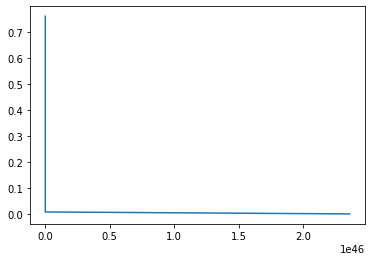

In [202]:
plt.plot(bic,sorted(alphas['alphas']))


In [194]:
test = [3,5,6,29,0]

In [197]:
sorted(test)

[0, 3, 5, 6, 29]

In [203]:
model2.cv_results_

{'alphas': array([0.75985235, 0.59630171, 0.46795371, 0.36723134, 0.28818845,
        0.22615876, 0.17748034, 0.17343039, 0.16947285, 0.16560562,
        0.16182664, 0.15813389, 0.1545254 , 0.15099926, 0.14755358,
        0.14418653, 0.14089632, 0.13927947, 0.13768118, 0.13453941,
        0.13146933, 0.12846931, 0.12553774, 0.12526206, 0.12498698,
        0.12471251, 0.12443864, 0.12416537, 0.1238927 , 0.12362063,
        0.12359475, 0.12356887, 0.123543  , 0.12351714, 0.12349128,
        0.12346543, 0.12343958, 0.12341374, 0.1233879 , 0.12336207,
        0.12334916, 0.12333624, 0.12331042, 0.12328461, 0.1232588 ,
        0.12323299, 0.12320719, 0.1231814 , 0.12315561, 0.12312983,
        0.12310405, 0.12307828, 0.122808  , 0.12267308, 0.12253831,
        0.12226921, 0.12200071, 0.12173279, 0.12146546, 0.12119872,
        0.12093257, 0.120667  , 0.12040201, 0.1201376 , 0.11987378,
        0.11713836, 0.11446536, 0.11185335, 0.10930095, 0.08577501,
        0.0673128 , 0.05282439, 0.0414

In [204]:
model2.score()

TypeError: score() missing 1 required positional argument: 'X_test'

In [205]:
model2.score(test)

ValueError: operands could not be broadcast together with shapes (5,) (100,) 